# Predicting sickness based on iris data


First of all, we import the necessary dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Storing and parsing the data

Then, we need to convert the csv dataset to a Pandas dataframe and parse the necessary values needed for our model later on (if any).

In [2]:
all_iris_df = pd.read_csv('iris_dataset.csv')

## Splitting into train and test dataframes
We need to create 2 new dataframes, one for training the model and the other for testing.
- Training will be used to calculate the appropriate weights that the model assigns to each class.
- Testing will be used to calculate the accuracy of the model.

In [3]:
def split_train_test(train_size):
    """
    Splits the dataset into training and testing sets.
    The function randomly samples the data to create a training set and uses the remaining data for testing.
    The split is done based on a specified train size percentage.
    Returns the training attributes, training class labels, testing attributes, and testing class labels. 
    """
    # Randomly sample the data
    train_iris_df = all_iris_df.sample(frac=train_size, random_state=150)

    # Get the remaining data for testing
    test_iris_df = all_iris_df.drop(train_iris_df.index)

    train_attributes =  np.array(train_iris_df.drop('variety', axis=1))
    train_class = np.array(train_iris_df['variety'])

    test_attributes =  np.array(test_iris_df.drop('variety', axis=1))
    test_class = np.array(test_iris_df['variety'])

    return train_attributes, train_class, test_attributes, test_class

## Training the model
We'll be using a Multiclass Perceptron algorithm to predict the outcomes in our model.<br><br>
Firstly, we need to initialize the weights for each class.

In [4]:
def init_weights(all_zeros=True):
    """
    Initializes the weights for the perceptron algorithm.
    If all_zeros is True, initializes weights to zero.
    If all_zeros is False, initializes weights randomly between -0.5 and 0.5.
    """

    # NOTE
    # Each nth element of a class' weight belongs to the nth attributes of the iris data
    # [     w1     ,     w2     ,     w3      ,     w4     ]
    # [sepal.length, sepal.width, petal.length, petal.width]

    # The weights are initialized to zero or randomly between -0.5 and 0.5
    # If all_zeros is True, all weights are set to zero
    # If all_zeros is False, weights are randomly initialized
    # Randomly initialize the weights for each class
    # The weights are initialized between -0.5 and 0.5
    # This works because np.random.rand() returns a value between 0 and 1
    # and subtracting 0.5 gives a value between -0.5 and 0.5
    weights = {
        'setosa': np.zeros(4) if all_zeros else np.random.rand(4) - 0.5,
        'versicolor': np.zeros(4) if all_zeros else np.random.rand(4) - 0.5,
        'virginica': np.zeros(4) if all_zeros else np.random.rand(4) - 0.5
    }

    return weights

Now, we train our model and calculate the final weights.<br>
Here's how Multiclass Perceptron works in our case:
1. For each epoch:
    - For each training example:
        - Calculate the weighted sum for each class.
        - Predict the class with the highest score.
        - If the prediction is incorrect:
            - Update the weights for the true class and the predicted class.
            - Set the flag `inaccurate` to True.
    - If `inaccurate` is False, break the loop.
2. The final weights are stored in the `weights` dictionary.

For a more detailed explanation of the algorithm, view [`algorithm.txt`](./algorithm.txt)

In [5]:
def multiclass_perceptron(train_attributes, train_class, model_settings):
    weights, learning_rate, max_epochs = model_settings
    inaccurate = True
    epoch = 0
    classes = ['setosa', 'versicolor', 'virginica']
    
    while inaccurate and epoch < max_epochs:
        inaccurate = False
        for index, data in enumerate(train_attributes):
            setosa_sum = np.dot(weights['setosa'], data)
            versicolor_sum = np.dot(weights['versicolor'], data)
            virginica_sum = np.dot(weights['virginica'], data)

            # Get index of the highest sum and get the name of the class
            prediction = classes[np.argmax([setosa_sum, versicolor_sum, virginica_sum])]

            expected = train_class[index].lower()

            # If the prediction is wrong...
            if prediction != expected:
                inaccurate = True
                
                # Increase weight for expected class
                weights[expected] = weights[expected] + (learning_rate * data)

                # Decrease weight for predicted class
                weights[prediction] = weights[prediction] - (learning_rate * data)
        epoch += 1
        
    return epoch, weights


## Testing the model
To test the model, we define a function that calculates the accuracy by comparing the predicted class labels with the actual class labels. The function iterates through the test set, makes predictions using the learned weights, and calculates the percentage of correct predictions.

In [6]:
# Test the model on the test set
def test_model(test_attributes, test_class, weights):
    """
    Tests the model on the test set.
    The function calculates the accuracy of the model by comparing the predicted class labels with the actual class labels.
    Returns the accuracy of the model as a percentage.
    """
    classes = ['setosa', 'versicolor', 'virginica']
    correct_predictions = 0

    for index, data in enumerate(test_attributes):
        setosa_sum = np.dot(weights['setosa'], data)
        versicolor_sum = np.dot(weights['versicolor'], data)
        virginica_sum = np.dot(weights['virginica'], data)

        # Get index of the highest sum and get the name of the class
        prediction = classes[np.argmax([setosa_sum, versicolor_sum, virginica_sum])]

        expected = test_class[index].lower()

        # print(f"{index + 1}. Predicted: {prediction} Expected: {expected}")

        if prediction == expected:
            correct_predictions += 1

    accuracy = (correct_predictions / len(test_class)) * 100
    return accuracy

## Finally...
It's time to use the model! We're going to experiment using different settings or intiial values. <br><br>
For the `train-test split`, we'll try for:
1. 80-20 split
2. 70-30 split
3. 60-40 split

For the `learning rates`, we'll try using:
1. 0.1
2. 0.05

For the `initial weights`, we'll try using:
1. All zeros
2. Randomly within -0.5 and 0.5 range

For each of these, we'll first initialize and set all the model's necessary settings. This includes the weights, a limit epoch value, and the learning rate. A total of 12 trials will be conducted. All accuracies of these trials will be stored and evaluated.

In [7]:
accuracies = []
train_sizes = [0.8, 0.7, 0.6]
all_learning_rates = [0.1, 0.05]
weights_all_zeros = [True, False]
max_epochs = 1000
trial = 0

for train_size in train_sizes:
    for learning_rate in all_learning_rates:
        for using_all_zeros in weights_all_zeros:
            trial += 1
            train_attributes, train_class, test_attributes, test_class = split_train_test(train_size)
            model_settings = [init_weights(all_zeros=using_all_zeros), learning_rate, max_epochs]
            final_epochs, final_weights = multiclass_perceptron(train_attributes, train_class, model_settings)
            accuracy = test_model(test_attributes, test_class, final_weights)
            accuracies.append(accuracy)

            # Display the trial results neatly, showing all settings and accuracy of current model
            print(f"======= Trial {trial} =======")
            print(f"Initial weights: {"all zeros" if using_all_zeros else "random"}")
            print(f"Learning rate: {learning_rate}")
            print(f"Final epochs: {final_epochs}")
            print(f"Final weights: {final_weights}")
            print(f"Model accuracy: {accuracy:.2f}%")
            print()


======= Trial 1 =======
Initial weights: all zeros
Learning rate: 0.1
Final epochs: 1000
Final weights: {'setosa': array([  9.52,  12.18, -18.43,  -9.63]), 'versicolor': array([ 10.42,   4.75, -10.94, -10.9 ]), 'virginica': array([-19.94, -16.93,  29.37,  20.53])}
Model accuracy: 100.00%

======= Trial 2 =======
Initial weights: random
Learning rate: 0.1
Final epochs: 1000
Final weights: {'setosa': array([  9.60876068,  12.40475373, -18.64510719,  -9.99021581]), 'versicolor': array([ 10.00073836,   4.8312213 , -10.70068064, -10.72685382]), 'virginica': array([-19.83752962, -16.76842578,  29.59740037,  20.71640474])}
Model accuracy: 100.00%

======= Trial 3 =======
Initial weights: all zeros
Learning rate: 0.05
Final epochs: 1000
Final weights: {'setosa': array([ 4.76 ,  6.09 , -9.215, -4.815]), 'versicolor': array([ 5.21 ,  2.375, -5.47 , -5.45 ]), 'virginica': array([-9.97 , -8.465, 14.685, 10.265])}
Model accuracy: 100.00%

======= Trial 4 =======
Initial weights: random
Learning rat

## Visualizing the results

To better understand the results of our trials, we have plotted a bar graph that visually represents the accuracy of the model for each trial. Each bar corresponds to a specific trial, with details such as train size, learning rate, and initial weight settings labeled on the x-axis. The y-axis represents the accuracy percentage achieved by the model.

This visualization helps us quickly identify which combinations of settings yielded the best performance and provides insights into the impact of different parameters on the model's accuracy.

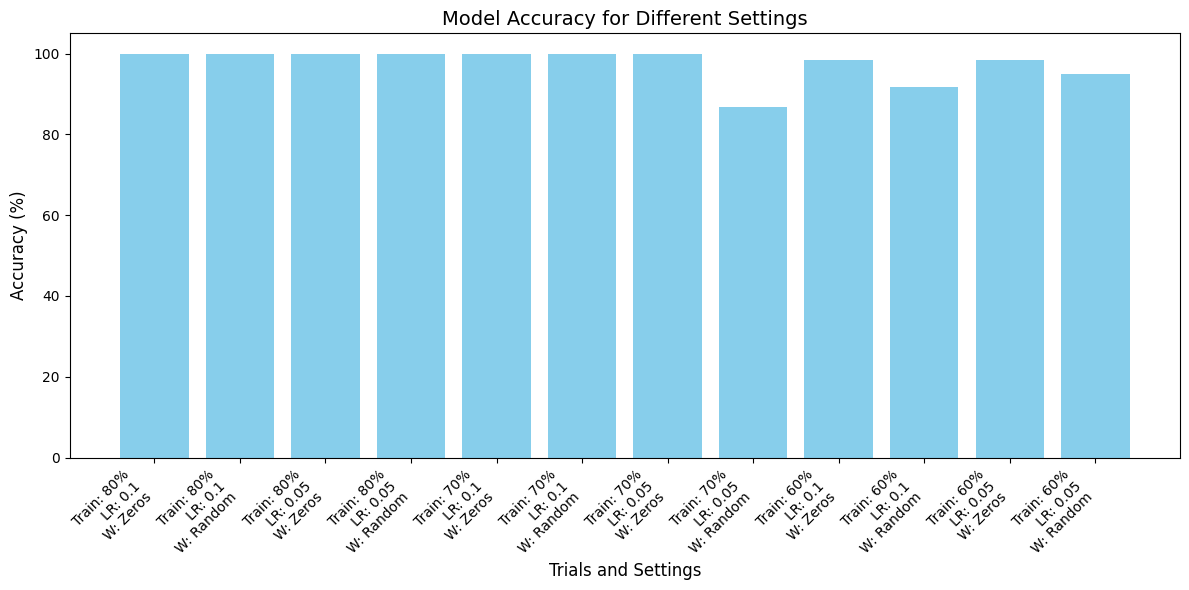

In [11]:
# Prepare data for the graph
x_labels = [
    f"Train: {int(train_sizes[i//4] * 100)}%\nLR: {all_learning_rates[(i//2) % 2]}\nW: {'Zeros' if weights_all_zeros[i % 2] else 'Random'}"
    for i in range(len(accuracies))
]

# Plot the graph
plt.figure(figsize=(12, 6))
plt.bar(x_labels, accuracies, color='skyblue')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.xlabel("Trials and Settings", fontsize=12)
plt.ylabel("Accuracy (%)", fontsize=12)
plt.title("Model Accuracy for Different Settings", fontsize=14)
plt.tight_layout()
plt.show()